In [1]:
import numpy as np
import scipy 
import pandas as pd
import itertools
from matplotlib import pyplot as plt

In [2]:
# load information from aafco 
contents = open("AAFCO_cat.txt", "r")
temp = [r[:-1].split(' ') for r in contents.readlines()]
# print(temp)
col_name = ['id', 'Unit(DM based)','Growth Min', 'Adule Maintenance Min', 'Adule Maintenance Max']
# construct df to store AACFO baselines

aafco = pd.DataFrame(temp, columns =col_name)
# check nutrition list
aafco['id'] = aafco['id'].apply(lambda x: x.replace('_', ' '))
# the same type of nutri for home made meal
aafco.drop(index=(26), inplace=True)


In [3]:
# check units
print(aafco[['id', 'Unit(DM based)']])

                                       id Unit(DM based)
0                           Crude Protein              g
1                                Arginine              g
2                               Histidine              g
3                              Isoleucine              g
4                                 Leucine              g
5                                  Lysine              g
6                              Methionine              g
7                      Methionine-cystine              g
8                           Phenylalanine              g
9                  Phenylalanine-tyrosine              g
10                              Threonine              g
11                             Tryptophan              g
12                                 Valine              g
13                              Crude Fat              g
14                          Linoleic acid              g
15                   alpha-Linolenic acid              g
16                       Arachi

In [4]:
# we focus on the adult version 
aafco = aafco[['id', 'Unit(DM based)', 'Adule Maintenance Min', 'Adule Maintenance Max']]

In [5]:
# list of ingredients and their fdc_id in legacy food 
protein = {'chicken, dark meat, cooked': 172376, 'beef, 10% gound, cooked': 174031, 'pork, 14% ground, cooked': 169192}
carb = {'rice, white, cooked': 169711, 'whie potatoes, baked': 170434}
# fat = {}
fiber = {'pumpkin, cooked': 168449, 'chickpea, cooked': 173757, 'Sweet potato, cooked': 168484}

In [6]:
# read usda nutrition data, for each food, we wish to store a vector of nutrients 
path = './FoodData_Central_sr_legacy_food_csv_2018-04/'
# list of nutriant from aafco 
nutri = list(aafco['id'])

# get a list of nutri id 
nutri_info = pd.read_csv(path + 'nutrient.csv', dtype = {'name' :'str'})
nutri_info.set_index('id')
# read food nutriant 
food_info = pd.read_csv(path + 'food_nutrient.csv')

In [7]:
nutri_info.head()

,id,name,unit_name,nutrient_nbr,rank
0,2047,Energy (Atwater General Factors),KCAL,957.0,280.0
1,2048,Energy (Atwater Specific Factors),KCAL,958.0,290.0
2,1001,Solids,G,201.0,200.0
3,1002,Nitrogen,G,202.0,500.0
4,1003,Protein,G,203.0,600.0


In [8]:
nutri_info['name'] = nutri_info['name'].astype(str)

In [9]:
# get a list of food we are interested in 
fdc_id_list = list(protein.values()) + list(carb.values()) + list(fiber.values())

In [10]:
food_info.head()

,id,fdc_id,nutrient_id,amount,data_points,derivation_id,min,max,median,footnote,min_year_acquired
0,1283674,167512,1003,5.88,1,46.0,NaN,NaN,NaN,NaN,NaN
1,1283675,167512,1007,3.50,1,46.0,NaN,NaN,NaN,NaN,NaN
2,1283676,167512,1062,1286.00,0,49.0,NaN,NaN,NaN,NaN,NaN
3,1283677,167512,1079,1.20,1,46.0,NaN,NaN,NaN,NaN,NaN
4,1283678,167512,1089,2.12,1,46.0,NaN,NaN,NaN,NaN,NaN


In [11]:
# get all data needed for analysis, ignore min/max etc
food_info_filtered = food_info[food_info['fdc_id'].apply(lambda x: x in fdc_id_list)][['fdc_id', 'nutrient_id', 'amount']]
def map_nutri_name(x):
    return nutri_info[nutri_info['id'] == x]['name'].item()

food_info_filtered['nutri_name'] = food_info_filtered['nutrient_id'].apply(map_nutri_name)
food_info_filtered.head()

,fdc_id,nutrient_id,amount,nutri_name
77714,168449,1261,0.0,SFA 8:0
77715,168449,1272,0.0,PUFA 22:6 n-3 (DHA)
77716,168449,1278,0.0,PUFA 20:5 n-3 (EPA)
77717,168449,1280,0.0,PUFA 22:5 n-3 (DPA)
77718,168449,1018,0.0,"Alcohol, ethyl"


In [12]:
# prepare 
USDA_nutri = set(food_info_filtered['nutri_name'])

# print(USDA_nutri)


In [13]:
# Use AAFCO list of nutri as columns, combine nutrients of the same type
nutri_col = list(aafco['id'])
nutri_map = {}
Ignore_list = ['Taurine (extruded)', 'Taurine (canned)', 'Biotin', 'Chloride', 'Iodine']
for nutri in nutri_col:
    if not nutri in Ignore_list:
        if nutri == 'Linoleic acid':
    #         omega-6 
            nutri_map[nutri] = [t for t in USDA_nutri if 'n-6' in t]
        elif nutri == 'alpha-Linolenic acid':
    #         polyunsaturated n−3 according to wiki
            nutri_map[nutri] = [t for t in USDA_nutri if '(ALA)' in t]
        elif nutri == 'Arachidonic acid':
            nutri_map[nutri] = ['PUFA 20:4 n-6']
        elif nutri == 'Eicosapentaenoic+Docosahexaenoic acid':
            nutri_map[nutri] = [t for t in USDA_nutri if 'EPA' in t or 'DHA' in t]
        elif nutri == 'Pyridoxine':
            nutri_map[nutri] = ['Vitamin B-6']
        elif nutri == 'Copper (extruded)':
            nutri_map[nutri] = [t for t in USDA_nutri if 'Copper' in t]
        elif nutri == 'Methionine':
            nutri_map[nutri] = ['Methionine', 'Cystine']
        elif nutri == 'Methionine-cystine':
            nutri_map[nutri] = ['Cystine']
        elif nutri == 'Crude Fat':
            nutri_map[nutri] = ['Total lipid (fat)']
        elif nutri == 'Vitamin A':
            nutri_map[nutri] = ['Vitamin A, IU']
        elif nutri == 'Vitamin D':
            nutri_map[nutri] = ['Vitamin D (D2 + D3), International Units']
        else: 
            temp = nutri.replace('-', ' ').lower()
            nutri_map[nutri] = [t for t in USDA_nutri if t.replace('-', '').lower() in temp or temp in t.replace('-', '').lower()]

    
nutri_col = list(nutri_map.keys())

In [14]:
# construct nutri info for each ingredient  
ingredients_info = food_info_filtered.pivot(index = 'fdc_id', columns = 'nutrient_id',  values='amount').fillna(0)
nutri_info.set_index('name', inplace = True)


In [15]:
# rename columns 
rev_map = {v:k for k, v in nutri_info['id'].to_dict().items()}
ingredients_info.rename(columns = rev_map, inplace = True)

In [16]:
ingredients_info['Energy']

fdc_id
168449      83.0
168484     320.0
169192    1211.0
169711     406.0
170434     385.0
172376     648.0
173757     686.0
174031     910.0
Name: Energy, dtype: float64

In [17]:
nutri_info.reset_index(inplace = True)

In [18]:
unit = {}
for n in nutri_col:
    cur_list = nutri_map[n]
#     check unit matches 
    cur_units = list(nutri_info[nutri_info['name'].apply(lambda x :x in cur_list)].unit_name)
    print(n, cur_units)
    if (len(set(cur_units)) > 1):
        print(n, ' unit inconsistent')
    unit[n] = cur_units[0]
#     convert vitamine E unit 
    if n == 'Vitamin E':
        ingredients_info[n] = ingredients_info['Vitamin E (alpha-tocopherol)']/0.67 + ingredients_info['Vitamin E, added']/0.45
        unit[n] = 'iu'
    else:
        ingredients_info[n] = ingredients_info[cur_list].sum(axis = 1)
data = ingredients_info[nutri_col + ['Energy']]
# data['Energy'] = ingredients_info['Energy']

Crude Protein ['G']
Arginine ['G']
Histidine ['G']
Isoleucine ['G', 'G']
Leucine ['G', 'G']
Lysine ['G']
Methionine ['G', 'G']
Methionine-cystine ['G']
Phenylalanine ['G', 'G']
Phenylalanine-tyrosine ['G', 'G', 'G']
Threonine ['G']
Tryptophan ['G']
Valine ['G']
Crude Fat ['G']
Linoleic acid ['G', 'G', 'G', 'G']
alpha-Linolenic acid ['G']
Arachidonic acid ['G']
Eicosapentaenoic+Docosahexaenoic acid ['G', 'G']
Calcium ['MG']
Phosphorus ['MG']
Potassium ['MG']
Sodium ['MG']
Magnesium ['MG']
Iron ['MG']
Copper (extruded) ['MG']
Manganese ['MG']
Zinc ['MG']
Selenium ['UG']
Vitamin A ['IU']
Vitamin D ['IU']
Vitamin E ['MG', 'MG']
Vitamin K ['UG', 'UG']
Thiamine ['MG']
Riboflavin ['MG']
Pantothenic acid ['MG']
Niacin ['MG']
Pyridoxine ['MG']
Folic acid ['UG']
Vitamin B12 ['UG', 'UG']
Choline ['MG']


In [20]:
# check the data
data.head()

nutrient_id,Crude Protein,Arginine,Histidine,Isoleucine,Leucine,Lysine,Methionine,Methionine-cystine,Phenylalanine,Phenylalanine-tyrosine,...,Vitamin K,Thiamine,Riboflavin,Pantothenic acid,Niacin,Pyridoxine,Folic acid,Vitamin B12,Choline,Energy
fdc_id,,,,,,,,,,,,,,,,,,,,,
168449,0.72,0.039,0.011,0.057,0.091,0.039,0.010,0.002,0.043,0.093,...,0.8,0.031,0.078,0.201,0.413,0.044,0.0,0.00,6.2,83.0
168484,1.37,0.048,0.027,0.129,0.210,0.058,0.044,0.019,0.145,0.242,...,2.1,0.056,0.047,0.581,0.538,0.165,0.0,0.00,10.8,320.0
169192,26.69,1.741,1.055,3.349,5.478,2.296,1.021,0.308,2.709,5.412,...,0.0,0.421,0.486,0.915,9.286,0.613,0.0,1.02,89.7,1211.0
169711,2.02,0.168,0.047,0.254,0.421,0.073,0.088,0.041,0.225,0.409,...,0.0,0.020,0.013,0.215,0.290,0.026,0.0,0.00,2.1,406.0
170434,2.10,0.103,0.035,0.168,0.268,0.109,0.057,0.025,0.147,0.260,...,2.7,0.048,0.043,0.383,1.528,0.211,0.0,0.00,14.4,385.0


In [23]:
nutri_info[nutri_info['name'].apply(lambda x :x in USDA_nutri)].unit_name.apply(lambda x: x.lower())

4         g
5         g
6         g
8         g
9      kcal
       ... 
404       g
405       g
406       g
411       g
415       g
Name: unit_name, Length: 136, dtype: object

In [24]:
# replace non-determined requirement with 0 
aafco.replace('ND', 0, inplace = True)

In [26]:
# set up constrains based on aafco
aafco_units = aafco.set_index('id')[['Unit(DM based)']].to_dict()['Unit(DM based)']
for v in aafco_units:
    if v in unit:
        aafco_unit = aafco_units[v].lower()
        usda_unit = unit[v].lower()
        
        if aafco_unit != usda_unit:
            if  aafco_unit == 'g' and usda_unit == 'mg':
                aafco_units[v] = 'mg'
                aafco[aafco['id'] == v][['Adule Maintenance Min', 'Adule Maintenance Max']].astype(float).apply(lambda x: x * 1000)
            elif aafco_unit == 'mg' and usda_unit == 'ug':
                aafco_units[v] = 'ug'
                aafco[aafco['id'] == v][['Adule Maintenance Min', 'Adule Maintenance Max']].astype(float).apply(lambda x: x * 1000)
            

In [27]:
# get matrix A, row: ingredients; columns: nutri from aafco 
aafco['Adule Maintenance Max'].astype(float)
aafco['Adule Maintenance Min'].astype(float)
A = pd.concat([data, aafco.set_index('id')[['Adule Maintenance Min', 'Adule Maintenance Max']].T])
A

,Crude Protein,Arginine,Histidine,Isoleucine,Leucine,Lysine,Methionine,Methionine-cystine,Phenylalanine,Phenylalanine-tyrosine,...,Pyridoxine,Folic acid,Vitamin B12,Choline,Energy,Chloride,Iodine,Biotin,Taurine (extruded),Taurine (canned)
168449,0.72,0.039,0.011,0.057,0.091,0.039,0.01,0.002,0.043,0.093,...,0.044,0.0,0.0,6.2,83.0,NaN,NaN,NaN,NaN,NaN
168484,1.37,0.048,0.027,0.129,0.21,0.058,0.044,0.019,0.145,0.242,...,0.165,0.0,0.0,10.8,320.0,NaN,NaN,NaN,NaN,NaN
169192,26.69,1.741,1.055,3.349,5.478,2.296,1.021,0.308,2.709,5.412,...,0.613,0.0,1.02,89.7,1211.0,NaN,NaN,NaN,NaN,NaN
169711,2.02,0.168,0.047,0.254,0.421,0.073,0.088,0.041,0.225,0.409,...,0.026,0.0,0.0,2.1,406.0,NaN,NaN,NaN,NaN,NaN
170434,2.1,0.103,0.035,0.168,0.268,0.109,0.057,0.025,0.147,0.26,...,0.211,0.0,0.0,14.4,385.0,NaN,NaN,NaN,NaN,NaN
172376,24.24,1.692,0.723,3.222,5.287,2.286,0.976,0.283,2.419,4.781,...,0.407,0.0,0.38,70.3,648.0,NaN,NaN,NaN,NaN,NaN
173757,8.86,0.835,0.244,1.011,1.642,0.593,0.235,0.119,0.855,1.455,...,0.139,0.0,0.0,42.8,686.0,NaN,NaN,NaN,NaN,NaN
174031,26.11,1.698,0.848,3.189,5.224,2.161,0.94,0.269,2.652,5.089,...,0.397,0.0,2.56,83.9,910.0,NaN,NaN,NaN,NaN,NaN
Adule Maintenance Min,65,2.60,0.78,1.30,3.10,2.08,0.5,1.00,1.05,3.83,...,1.0,0.20,0.005,600,NaN,0.75,0.15,0.018,0.25,0.5
Adule Maintenance Max,None,None,None,None,None,None,3.75,None,None,None,...,None,None,None,None,NaN,16,None,None,None,None


In [28]:
A = A.fillna(0)

In [29]:
# get upper and lower bound
A_low = A[nutri_col].to_numpy()[:-2]

max_bound = list(aafco['id'][aafco['Adule Maintenance Max'].notna()])
A_up = A[max_bound].to_numpy()[:-2]

A_opt = np.concatenate((-A_low, A_up), axis = 1).T

A_eq = A[['Energy']].to_numpy()[:-2].T
A_opt.shape

(45, 8)

In [30]:
# write aafco constrain
b_low = A[nutri_col].to_numpy()[-2].astype(float)
b_up = A[max_bound].to_numpy()[-1].astype(float)
b_opt = np.concatenate((-b_low, b_up), axis = 0)
# combined energy is 1000
b_eq = 1000
# say objective is to minimize carb 
c = [0 for i in range(A_opt.shape[1])]
for f in carb: 
    i_f = list(data.index).index(carb[f])
    c[i_f] = 1

In [31]:
# check if this program is not feasible
# Note: this shouldn't be feasible because we didn't add any suppliment
scipy.optimize.linprog(c, A_opt, b_opt, A_eq, b_eq)

       message: The problem is infeasible. (HiGHS Status 8: model_status is Infeasible; primal_status is At lower/fixed bound)
       success: False
        status: 2
           fun: None
             x: None
           nit: 0
         lower:  residual: None
                marginals: None
         upper:  residual: None
                marginals: None
         eqlin:  residual: None
                marginals: None
       ineqlin:  residual: None
                marginals: None

In [33]:
# from recipe in gram, get constrain 
recipe = {'Protein':86, 'carb': 80, 'fiber': 5.69}
rec_v = list(recipe.values())

size = len(nutri_col)
b_up_r = np.zeros(size)
b_low_r = np.zeros(size)
mean_r = np.zeros(size)
count = 0
for cur_rec in itertools.product(*[list(protein.values()), list(carb.values()), list(fiber.values())]):
    cur_nutri = np.dot(A[nutri_col].loc[list(cur_rec)].to_numpy().T, rec_v)/100
    b_up_r = np.maximum(cur_nutri, b_up_r)
    b_low_r = np.minimum(cur_nutri, b_up_r)
    mean_r = mean_r + cur_nutri
    count += 1
mean_r /= count

In [34]:
A_low_r = A[nutri_col].to_numpy()[:-2] 
A_up_r = A[nutri_col].to_numpy()[:-2]
A_opt_r = np.concatenate((-A_low_r, A_up_r), axis = 1).T

b_opt_r = np.concatenate((-b_low_r, b_up_r), axis = 0)
# check the shape 
print(A_opt_r.shape, b_opt_r.shape)


(80, 8) (80,)


In [35]:
opt = scipy.optimize.linprog(c, A_opt_r, b_opt_r)

In [36]:
temp_dic = fiber | carb | protein
rev_ingredient_map = {v:k for k, v in temp_dic.items()}
ing_list = list(A.index)[:-2]
# display result 
print([(rev_ingredient_map[ing_list[i]], opt.x[i])for i in range(len(ing_list))])

[('pumpkin, cooked', 0.0), ('Sweet potato, cooked', 0.05690000000000048), ('pork, 14% ground, cooked', 0.86), ('rice, white, cooked', 0.0), ('whie potatoes, baked', 0.8000000000000005), ('chicken, dark meat, cooked', -0.0), ('chickpea, cooked', -0.0), ('beef, 10% gound, cooked', -0.0)]


In [37]:
# filter some ingredients, check the one we are most interested in
combined_max = set(['Crude Protein','Phosphorus', 'Calcium', 'Sodium'])
combined_max_idx = [A.columns.get_loc(t) for t in combined_max]
# A.to_numpy().T[combined_max_idx]

In [38]:
A_low_r = A[nutri_col].to_numpy()[:-2].T[combined_max_idx] * -1
A_up_r = A[nutri_col].to_numpy()[:-2].T[combined_max_idx]
A_opt_r = np.concatenate((A_low_r, A_up_r), axis = 0)
A_eq = np.ones((1, A.shape[0] - 2))
b_eq = np.sum(rec_v)/100
# b_up_r[0] = 100
b_opt_r = np.concatenate((-b_low_r[combined_max_idx], b_up_r[combined_max_idx]), axis = 0)
# check the shape 
print(A_opt_r.shape, b_opt_r.shape)
# increase protein, decrease carb
c = [0 for i in range(A_opt.shape[1])]
for f in carb: 
    i_f = list(data.index).index(carb[f])
    c[i_f] = 1
for f in protein:
    i_f = list(data.index).index(protein[f])
    c[i_f] = -5

(8, 8) (8,)


In [39]:
# find opt recipe 
opt_r = scipy.optimize.linprog(c, A_opt_r, b_opt_r, A_eq, b_eq)
print([(rev_ingredient_map[ing_list[i]], opt_r.x[i])for i in range(len(ing_list))])
print('total carb', sum([opt_r.x[i] for i in range(len(ing_list)) if ing_list[i] in carb.values()])/sum(opt_r.x) * 100, '%')
print('original', (recipe['carb']/sum(rec_v))* 100, '%')

[('pumpkin, cooked', 0.18174430647219753), ('Sweet potato, cooked', 0.0), ('pork, 14% ground, cooked', 0.09650454446894985), ('rice, white, cooked', 0.0), ('whie potatoes, baked', 0.4171129339524098), ('chicken, dark meat, cooked', 0.8130172991105726), ('chickpea, cooked', 0.20852091599587025), ('beef, 10% gound, cooked', 0.0)]
total carb 24.294538642460818 %
original 46.5956083639117 %


(0.0, 1000.0)

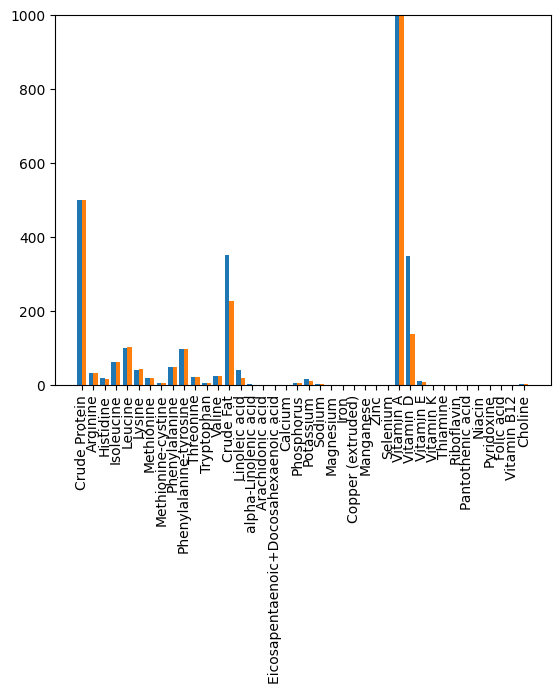

In [40]:
# see some nutritional value and how it compare to mean
opt_r_nutr = np.dot(A[nutri_col].to_numpy()[:-2].T, opt.x) 

X_axis = np.arange(len(mean_r)) 

for (i, n) in enumerate(nutri_col):
    if unit[n] == 'MG':
        opt_r_nutr[i] /= 1000
        mean_r[i] /= 1000
    elif unit[n] == 'UG':
        opt_r_nutr[i] /= 10**6
        mean_r[i] /= 10**6
    
plt.bar(X_axis - 0.2, opt_r_nutr/opt_r_nutr[0] * 500, 0.4)
plt.bar(X_axis + 0.2, mean_r/mean_r[0] * 500, 0.4)

# plt.bar(X_axis, nutri_col, mean_r/mean_r[0] * 500, 0.4)

plt.xticks(X_axis, nutri_col, rotation=90)
plt.ylim(0, 1000)


In [301]:
type(opt_r_nutr)

numpy.ndarray